## Attention U-NET Model

### Attention U-NET architecture

The Attention U-Net model is an extension of the original U-Net architecture, incorporating attention mechanisms to improve segmentation accuracy, especially in complex images with varying levels of detail. Key functionality of the Attention U-Net model includes:

Encoder: Similar to the traditional U-Net, the encoder captures high-level semantic features from the input image using convolutional layers and max-pooling operations. This progressively reduces the spatial dimensions while increasing the depth of the feature maps.

Bottleneck: The bottleneck section captures the most abstract features of the image and contains the encoded information. This part of the network allows the model to retain important features for segmentation while minimizing the spatial resolution.

Decoder: The decoder restores the spatial resolution of the feature maps, gradually increasing the image size using upsampling or transposed convolutional layers. The goal is to reconstruct the segmentation mask from the encoded features.

Skip Connections with Attention Gates: The main innovation of the Attention U-Net is the use of attention gates in the skip connections between the encoder and decoder. These attention gates help the model focus on the most relevant features by learning to suppress irrelevant regions in the feature maps. This allows the decoder to focus on high-priority areas of the image, improving segmentation accuracy, especially in cases where the background or irrelevant details might otherwise confuse the model.

Attention Mechanism: Attention gates apply a learned attention map that is multiplied with the feature map from the encoder before passing it to the decoder. This ensures that only important features from the encoder are passed to the decoder, allowing the model to focus more on relevant regions of interest (e.g., tumors, organs, or structures) and ignore irrelevant information in the background.

By using attention mechanisms in conjunction with the traditional U-Net structure, the Attention U-Net model enhances the performance of image segmentation tasks by allowing for more accurate and context-aware segmentations, particularly in challenging or cluttered images.

### Download Data

In [ ]:

!wget --no-check-certificate 'https://drive.usercontent.google.com/download?id=1cfORNOh_p1KHbhw8U0zhGkjSC2IrGaTB&export=download&confirm=t&uuid=c5760839-02fd-436b-9e38-9635cd7d8aab&at=APZUnTVLTsvNxsW4SInOAOYrK9ZA%3A1715907782351' -O images.zip


--2024-12-09 15:15:08--  https://drive.usercontent.google.com/download?id=1cfORNOh_p1KHbhw8U0zhGkjSC2IrGaTB&export=download&confirm=t&uuid=c5760839-02fd-436b-9e38-9635cd7d8aab&at=APZUnTVLTsvNxsW4SInOAOYrK9ZA%3A1715907782351
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.191.33, 2607:f8b0:4005:80f::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.191.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 748584920 (714M) [application/octet-stream]
Saving to: ‘images.zip’

images.zip          100%[===================>] 713.91M  19.2MB/s    in 34s     

2024-12-09 15:15:45 (20.8 MB/s) - ‘images.zip’ saved [748584920/748584920]



In [4]:
!unzip images.zip

Archive:  images.zip
  inflating: kaggle_3m/README.md     
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12_mask.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13_mask.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14_mask.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15.tif  
  inf

### Data Preprocessing

In [1]:
IMAGE_PATH = 'lgg-mri-segmentation/kaggle_3m'

In [2]:
## source: https://www.kaggle.com/code/saeedghamshadzai/image-segmentation-brain-tumor-u-net-cnn#Inferece
import os
paths = []

for dirname in os.listdir(IMAGE_PATH):
    if os.path.isdir(os.path.join(IMAGE_PATH, dirname)):

        for filename in os.listdir(os.path.join(IMAGE_PATH, dirname)):
            # Only the files with ',tif' format should be added to the 'paths' list
            if filename.endswith('.tif'):
                paths.append(IMAGE_PATH+'/'+dirname+'/'+filename)

len(paths), paths[:20:5]

(7858,
 ['lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif',
  'lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif',
  'lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14_mask.tif',
  'lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_17.tif'])

In [3]:
## source https://www.kaggle.com/code/saeedghamshadzai/image-segmentation-brain-tumor-u-net-cnn#Inferece
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
def data_frame(data):
    # Storing only paths that don't end with 'mask.tiff'
    images = list(filter(lambda x: not x.endswith('mask.tif'), data))
    # Sorting images based on the number of each MRI.
    images.sort(key=lambda x: int(x.rsplit('_', 3)[-1][:-4]))
    # Sorting by the patient IDs (each patient has more than 1 MRIs)
    images.sort(key=lambda x: int(x.rsplit('_', 3)[-2]))

    # Storing the image IDs
    IDs = list(map(lambda x: x.rsplit('/', 3)[-1][:-4], images))

    # Storing only paths that end with 'mask.tiff'
    masks = list(filter(lambda x: x.endswith('mask.tif'), data))
    # Sorting masks based on the number of each MRI.
    masks.sort(key=lambda x: int(x.rsplit('_', 3)[-2]))
    # Sorting by the patient IDs (each patient has more than 1 MRIs)
    masks.sort(key=lambda x: int(x.rsplit('_', 3)[-3]))

    # Opens the images
    pixels = lambda x: Image.open(x)
    # Selects the largest pixel
    largest_pixel = lambda y: np.max(pixels(y))
    # Determines if the mask contains an abnormality or not (+ or -)
    # Remember that a negative image's mask is just an entirely black image.
    diagnotic_function = lambda z: 1 if largest_pixel(z) > 0 else 0
    # Storing the diagnosis corresponding to each image
    diagnoses = list(map(lambda x: diagnotic_function(x), masks))

    # Making the dataframe
    DataFrame = pd.DataFrame({'ID': IDs, 'Image': images, 'Mask': masks, 'Diagnosis': diagnoses})

    # Dividing the indexes into train, test, and validation
    train_index, test_index = train_test_split(DataFrame.index.values.tolist(), test_size=0.15, random_state=42)
    train_index, val_index = train_test_split(train_index, test_size=0.1, random_state=42)

    # Making train, test, and validation dataframes
    train_df, val_df, test_df = DataFrame.iloc[train_index], DataFrame.iloc[val_index], DataFrame.iloc[test_index]

    return train_df, val_df, test_df

# Making the dataframes
train_df, val_df, test_df = data_frame(paths)

print(len(train_df), len(val_df), len(test_df))

train_df.head()

3005 334 590


,ID,Image,Mask,Diagnosis
472,TCGA_DU_6408_19860521_31,lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19...,1
288,TCGA_DU_6405_19851005_23,lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19...,0
3666,TCGA_FG_6691_20020405_29,lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20...,lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20...,1
851,TCGA_DU_7018_19911220_36,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7018_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7018_19...,0
2796,TCGA_HT_A61B_19991127_11,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19...,0


### Visualizing

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

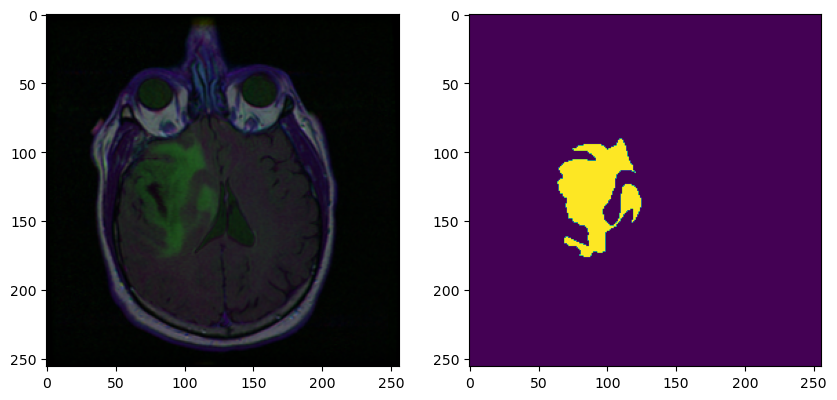

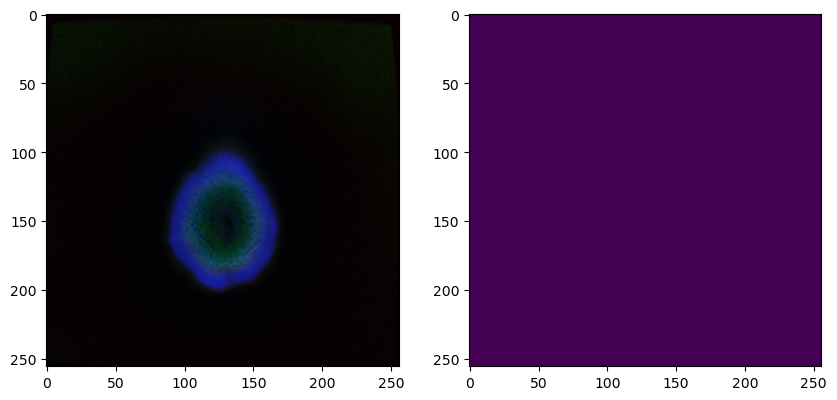

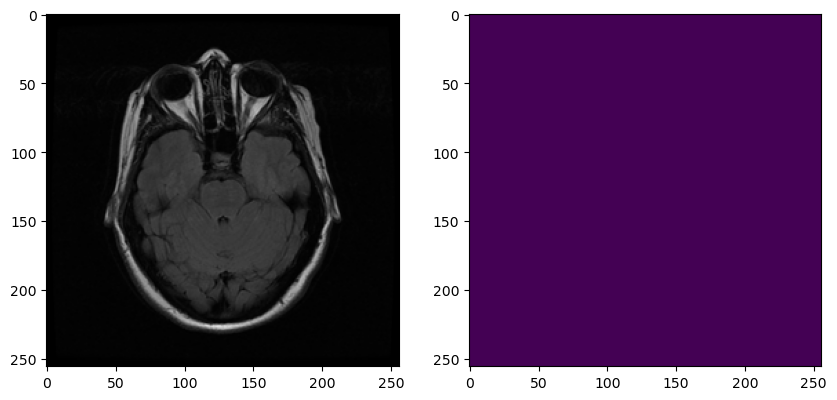

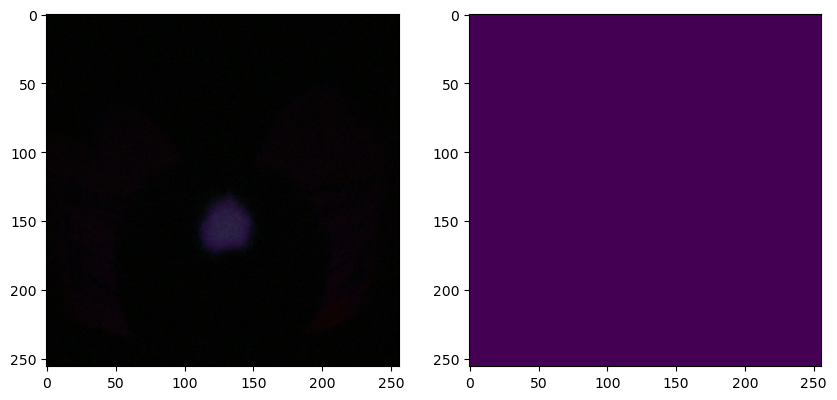

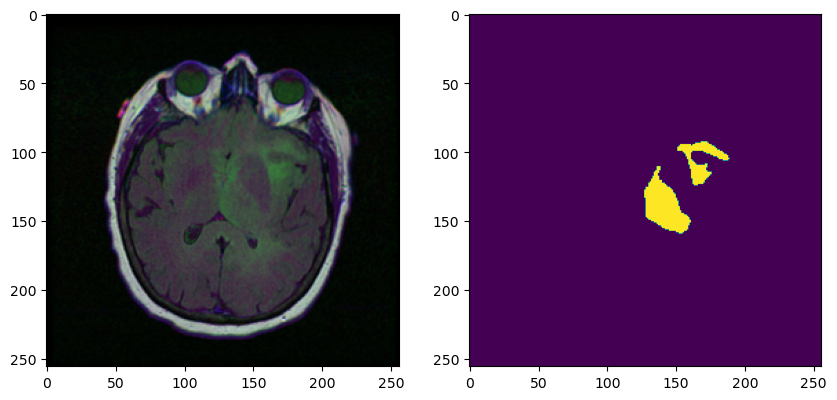

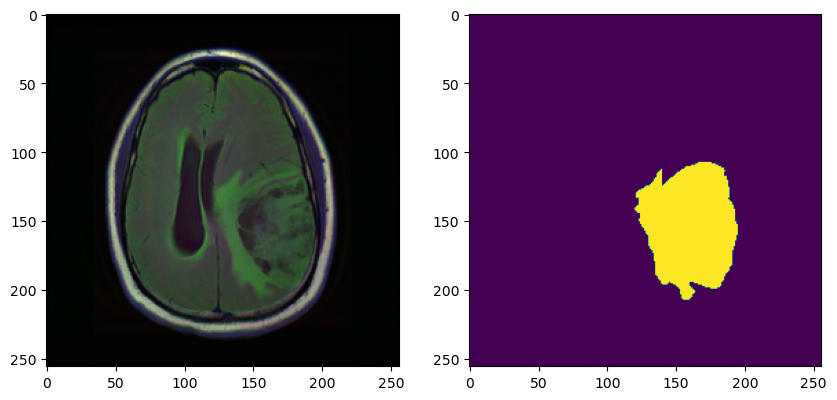

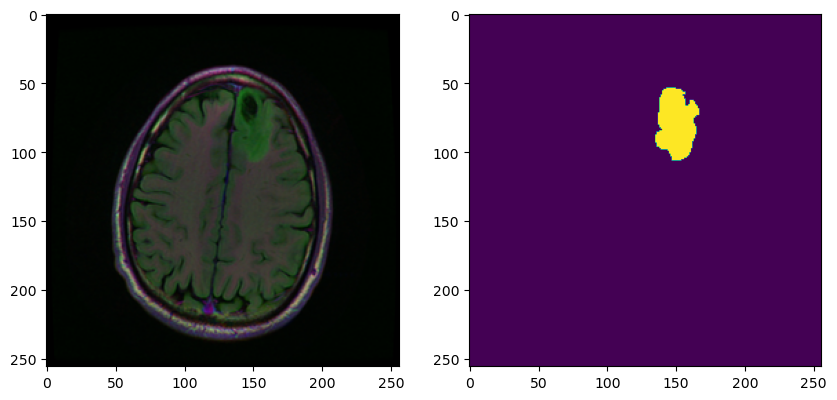

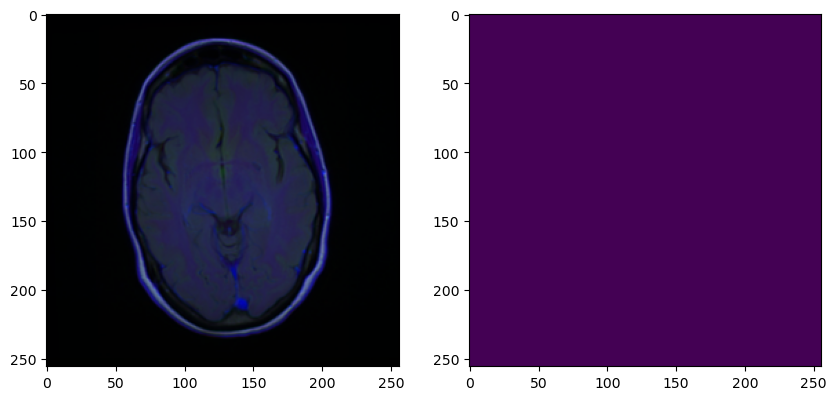

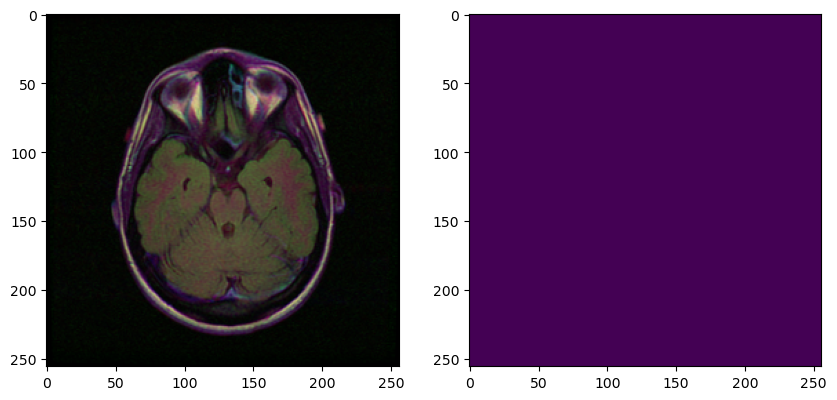

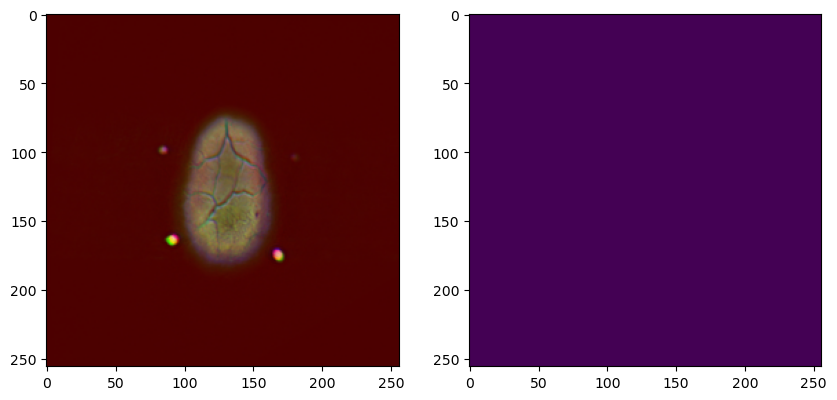

In [5]:
index = np.arange(train_df.shape[0])
rng = np.random.default_rng(37)
rng.shuffle(index)
for idx in range(10):
    image_path = train_df.iloc[index[idx]]['Image']
    mask_path = train_df.iloc[index[idx]]['Mask']
    image = Image.open(image_path).convert('RGB')
    mask = Image.open(mask_path).convert('L')
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[1].imshow(mask)

### Training the Model

Attention U-NET model with BCELoss

In [4]:
import torch

print(torch.cuda.is_available())
if (torch.cuda.is_available()):
    print(torch.cuda.get_device_name(0))
    print(torch.cuda.device_count())

True
NVIDIA GeForce RTX 2060
1


In [ ]:
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
PYDEVD_WARN_SLOW_RESOLVE_TIMEOUT=1.0

class AttentionUNET(nn.Module):
    def __init__(self, in_channels, out_channels,device):
        super(AttentionUNET, self).__init__()
       
        self.device = device
        self.pool = nn.MaxPool2d(2, 2)
        self.sigmoid = nn.Sigmoid()
        self.enc1 = self.encode_block(in_channels, 64)
        self.enc2 = self.encode_block(64, 128)
        self.enc3 = self.encode_block(128, 256)
        self.enc4 = self.encode_block(256, 512)
        #self.enc5 = self.encode_block(512, 1024)
        
        self.att3 = AttentionGate(F_g=256, F_l=256, F_int=128)
        self.att2 = AttentionGate(F_g=128, F_l=128, F_int=64)
        self.att1 = AttentionGate(F_g=64, F_l=64, F_int=32)
        
        #self.dec4 = self.decode_block(1024, 512)
        self.dec3 = self.decode_block(512, 256)
        self.dec2 = self.decode_block(256, 128)
        self.dec1 = self.decode_block(128, 64)
        
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
    # Encoder
    def encode_block (self, in_channels, out_channels): 
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3,stride=1,padding=1),#3x3 Conv
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),#Non-linearity function
            nn.Conv2d(out_channels, out_channels, kernel_size=3,stride=1,padding=1),  
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def up_conv(self, in_channels, out_channels):# Upsampling: Doubles spatial dimensions of feature maps, however ConvTranspose also halves the number of feature maps with 2x2 Conv here after.
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2).to(self.device)#Can be refitted inside constructor to avoid .to() but this works fine
    
    
    # Decoder
    def decode_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        x = self.enc1(x)
        enc1_pooled = self.pool(x)
        #print(f"enc1 shape: {x.shape}")
        
        enc2 = self.enc2(enc1_pooled)
        enc2_pooled = self.pool(enc2)
     
        enc3 = self.enc3(enc2_pooled)
        enc3_pooled = self.pool(enc3)
        
        enc4 = self.enc4(enc3_pooled)
        '''enc4_pooled = self.pool(enc4)
        
        enc5 = self.enc5(enc4_pooled)
      
        # Decoder path with upsampling
        
        dec = self.up_conv(1024,512)(enc5) 
        dec = torch.cat((dec, enc4), dim=1)
        dec = self.dec4(dec)'''
        
        dec = self.up_conv(512, 256)(enc4) 
        att  = self.att3(enc3,dec)
        dec = torch.cat((dec, att), dim=1)
        dec = self.dec3(dec)
        
        dec = self.up_conv(256, 128)(dec) 
        att = self.att2(enc2,dec)
        dec = torch.cat((dec, att), dim=1)
        dec = self.dec2(dec)
   
        dec = self.up_conv(128, 64)(dec)
        att = self.att1(x,dec)
        dec = torch.cat((dec, att), dim=1)
        dec = self.dec1(dec)
        
        dec = self.final_conv(dec)
        dec = self.sigmoid(dec)
        #print(f"Final output after 1x1 convolution: {dec}")
        return dec#,att_map1,att_map2,att_map3
        
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        
        # Downsample gating signal
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=3, stride=1, padding=2, dilation=2,bias=True),
            nn.BatchNorm2d(F_int)
        )
        # Downsample skip connection features
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=3, stride=1, padding=2, dilation=2,bias=True),
            nn.BatchNorm2d(F_int)
        )
        # Combine the two signals
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, g):
        g1 = self.W_g(g) 
        x1 = self.W_x(x)  
        psi = self.relu(g1 + x1)  
        psi = self.psi(psi)  
        return x * psi
        
if (torch.cuda.is_available()):
    print(torch.cuda.get_device_name(0))
    print(torch.cuda.device_count())
device = torch.device(0 if torch.cuda.is_available() else 'cpu')
print(device)
# Initialize the model

model = AttentionUNET(3,1,device=device).float().to(device)
checkpoint_path = 'latest_checkpoint.pth'

if os.path.exists(checkpoint_path):
    print("Resuming training from checkpoint...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])


NVIDIA GeForce RTX 2060
1
cuda:0


In [5]:

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd, 
    Rand2DElasticd, ToTensord,EnsureTyped,RandAffined, RandGaussianNoised,RandBiasFieldd, RandGridDistortiond, RandGaussianSmoothd
)
from monai.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')

        img = np.array(img)
        mask = np.array(mask)
        
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1) # Convert to float32 tensor
        mask = torch.tensor(mask, dtype=torch.long).unsqueeze(0) # Convert to long tensor for mask

        # Create the dictionary for transformations
        data = {"image": img, "semantic": mask}
        if not isinstance(data["image"], torch.Tensor):
            print(f"Warning: Image is not a tensor. Type: {type(data['image'])}")
        
        if not isinstance(data["semantic"], torch.Tensor):
            print(f"Warning: Mask is not a tensor. Type: {type(data['semantic'])}")

        if self.transform:
            data = self.transform(data)  

        return data["image"], data["semantic"]


# Define transformations
transform = Compose([
    RandAffined(keys=["image", "semantic"], rotate_range=(0.15, 0.15), translate_range=(13, 13), scale_range=(0.15, 0.15), prob=0.5, mode=("bilinear", "nearest")),
    Rand2DElasticd(
        keys=["image", "semantic"], 
        spacing=(10, 10),  # Adjust the spacing for the grid
        magnitude_range=(0.5, 0.80),  # Reduce the magnitude of distortion
        prob=0.5, 
        mode=("bilinear", "nearest")
    ),
    RandGridDistortiond(keys=["image", "semantic"], num_cells=5, distort_limit=0.15, prob=0.5, mode=("bilinear", "nearest")),
    RandGaussianNoised(keys=["image"], prob=0.5, mean=0.0, std=0.1),
    RandGaussianSmoothd(keys=["image"], sigma_x=(0.5, 1.5), sigma_y=(0.5, 1.5), prob=0.5),
    RandBiasFieldd(
    keys=["image"],
    coeff_range=(0.0, 0.1),  # Range for bias coefficients
    prob=0.5                 # Probability of applying the correction
    ),
    ScaleIntensityd(keys=["image", "semantic"]),  # Normalize image intensities
    EnsureTyped(keys=["image", "semantic"]),  # Ensure both are typed as tensors
])
# Transform
dev_transform = Compose([
    ScaleIntensityd(keys=["image", "semantic"]),  # Scales the intensity
    EnsureTyped(keys=["image", "semantic"]),
    ToTensord(keys=["image", "semantic"]),
  
])
test_transform = Compose([
    ScaleIntensityd(keys=["image", "semantic"]),  # Scales the intensity
    EnsureTyped(keys=["image", "semantic"]),
    ToTensord(keys=["image", "semantic"]),
  
])







In [6]:
from tqdm import tqdm
CUDA_LAUNCH_BLOCKING=1
PYDEVD_WARN_SLOW_RESOLVE_TIMEOUT=1.0
# Loss function and optimizer
criterion = nn.BCELoss()
#optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
#Optimizer determines how best to alter model parameters based on loss functions. UNET reccomended SGD with momentum added on top of learning rate
optimizer = optim.Adam(model.parameters(), lr=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

def visualize_attention_maps(att_maps):
    # att_maps is a tuple (att_map_1, att_map_2, att_map_3)
    fig, ax = plt.subplots(len(att_maps), 1, figsize=(15, 5))
    
    for i, att_map in enumerate(att_maps):
        # Process the attention map for the first item in the batch (index 0)
        att_map = att_map[0].squeeze().cpu().detach().numpy()  # Select the first item in the batch
        ax[i].imshow(att_map, cmap='jet')  # Use jet color map for better visualization
        ax[i].set_title(f'Attention Map {i+1}')
        ax[i].axis('off')
    
    plt.show()

# Training loop
def train(model, dataloader, dev_dataloader, criterion, optimizer, num_epochs=500, patience=7):
    model.train()
    best_dev_loss = np.inf
    early_stopping_counter = 0
    patience = patience
    print(f"NUM EPOCHS: {num_epochs}")
    # Load previous checkpoint if needed (optional)
    checkpoint_path = 'latest_checkpoint.pth'
    start_epoch = 0
    if os.path.exists(checkpoint_path):
        print("Resuming training from checkpoint...")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_dev_loss = checkpoint['best_dev_loss']
        print(f"CURRENT EPOCH FROM LAST CHECKPOINT: {checkpoint['epoch']}")
    else:
        print("CANT FIND CHECKPOINT PATH")

    # Main training loop
    for epoch in tqdm(range(start_epoch, num_epochs)):
        model.train()
        print(f"CURRENT EPOCH TRAINING: {epoch+1}")
        running_loss = 0.0
        i =0
        for images, masks in dataloader:
            # Move tensors to the appropriate device
            images = images.float().to(device)
            masks = masks.float().to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            #outputs, att_map1,att_map2,att_map3= model(images)
            outputs = model(images)
            '''if (epoch>=2 and i==30):
                visualize_attention_maps((att_map1, att_map2, att_map3))'''
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            #print(f"Images shape: {images.shape}, Mask shape: {mask.shape}")
            running_loss += loss.item() * images.size(0)
            i +=1

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

        # Validation loop
        model.eval()
        dev_loss = 0.0
        with torch.no_grad():
            for images, masks in tqdm(dev_dataloader, desc='Evaluating on dev set', unit='batch'):
                images = images.float().to(device)
                masks = masks.float().to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                dev_loss += loss.item() * images.size(0)
                
        dev_loss = dev_loss / len(dev_dataloader.dataset)
        print(f'Dev Loss: {dev_loss:.4f}')
        scheduler.step(dev_loss)
        # Save checkpoints every 2 epochs
        if (epoch+1) % 2 == 0:
            #print("INSIDE CHECKPOINT SAVER")
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_dev_loss': best_dev_loss,
            }
            torch.save(checkpoint, 'latest_checkpoint.pth')

        # Save the best model based on validation loss
        if dev_loss < best_dev_loss:
            best_dev_loss = dev_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f'Early stopping after {epoch+1} epochs.')
                torch.save(model.state_dict(), 'final_model.pth')
                break
        # Save a checkpoint after each epoch

def evaluate(model, dataloader):
    model.eval()
    with torch.no_grad():
        counter = 0
        for images, masks in dataloader:
            if counter > 10:
                break
            counter += 1
            # Move tensors to the appropriate device
            images = images.float().to(device)
            masks = masks.float().to(device)

            # Forward pass
            outputs = model(images)

            # Plot the results for visualization
            plt.figure(figsize=(18, 6))
            for i in range(min(len(images), 3)):
                plt.subplot(3, 3, i*3 + 1)
                plt.imshow(images[i].cpu().numpy().transpose(1, 2, 0))
                plt.title('Input Image')

                plt.subplot(3, 3, i*3 + 2)
                plt.imshow(outputs[i].cpu().numpy().squeeze(), cmap='gray')
                plt.title('Predicted Mask')

                plt.subplot(3, 3, i*3 + 3)
                plt.imshow(masks[i].cpu().numpy().squeeze(), cmap='gray')
                plt.title('Actual Mask')

            plt.show()


image_paths = train_df['Image'].values.tolist()
mask_paths = train_df['Mask'].values.tolist()

dev_paths = val_df['Image'].values.tolist()
dev_mask_paths = val_df['Mask'].values.tolist()
dataset = SegmentationDataset(image_paths, mask_paths, transform=transform)
dev_dataset = SegmentationDataset(dev_paths, dev_mask_paths, transform=dev_transform)

dataloader = DataLoader(dataset, batch_size=4,shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
# Training
train(model, dataloader, dev_dataloader, criterion, optimizer, num_epochs=500)


# Evaluation
evaluate(model, dataloader)


/home/mikhuz/miniconda3/envs/CapstoneWSL/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


NUM EPOCHS: 500
CANT FIND CHECKPOINT PATH


  0%|          | 0/500 [00:00<?, ?it/s]

CURRENT EPOCH TRAINING: 1
Epoch 1/500, Loss: 0.0951


  0%|          | 1/500 [05:50<48:30:54, 350.01s/it]

Dev Loss: 0.0459
CURRENT EPOCH TRAINING: 2
Epoch 2/500, Loss: 0.0310


Evaluating on dev set: 100%|██████████| 84/84 [00:14<00:00,  5.60batch/s]


Dev Loss: 0.0369


  0%|          | 2/500 [10:59<45:07:22, 326.19s/it]

CURRENT EPOCH TRAINING: 3
Epoch 3/500, Loss: 0.0294


  1%|          | 3/500 [16:03<43:38:13, 316.08s/it]

Dev Loss: 0.0320
CURRENT EPOCH TRAINING: 4
Epoch 4/500, Loss: 0.0269


Evaluating on dev set: 100%|██████████| 84/84 [00:16<00:00,  5.13batch/s]


Dev Loss: 0.0340


  1%|          | 4/500 [21:19<43:33:23, 316.14s/it]

CURRENT EPOCH TRAINING: 5
Epoch 5/500, Loss: 0.0254


  1%|          | 5/500 [26:39<43:39:21, 317.50s/it]

Dev Loss: 0.0308
CURRENT EPOCH TRAINING: 6
Epoch 6/500, Loss: 0.0245


Evaluating on dev set: 100%|██████████| 84/84 [00:15<00:00,  5.30batch/s]


Dev Loss: 0.0277


  1%|          | 6/500 [32:01<43:45:49, 318.93s/it]

CURRENT EPOCH TRAINING: 7
Epoch 7/500, Loss: 0.0234


  1%|▏         | 7/500 [37:33<44:15:18, 323.16s/it]

Dev Loss: 0.0353
CURRENT EPOCH TRAINING: 8
Epoch 8/500, Loss: 0.0236


Evaluating on dev set: 100%|██████████| 84/84 [00:16<00:00,  5.07batch/s]


Dev Loss: 0.0320


  2%|▏         | 8/500 [43:11<44:50:08, 328.07s/it]

CURRENT EPOCH TRAINING: 9
Epoch 9/500, Loss: 0.0223


  2%|▏         | 9/500 [48:43<44:54:34, 329.28s/it]

Dev Loss: 0.0293
CURRENT EPOCH TRAINING: 10
Epoch 10/500, Loss: 0.0196


Evaluating on dev set: 100%|██████████| 84/84 [00:16<00:00,  5.21batch/s]


Dev Loss: 0.0232


  2%|▏         | 10/500 [54:09<44:38:53, 328.03s/it]

CURRENT EPOCH TRAINING: 11
Epoch 11/500, Loss: 0.0176


  2%|▏         | 11/500 [59:33<44:23:33, 326.82s/it]

Dev Loss: 0.0250
CURRENT EPOCH TRAINING: 12
Epoch 12/500, Loss: 0.0173


Evaluating on dev set: 100%|██████████| 84/84 [00:16<00:00,  5.23batch/s]


Dev Loss: 0.0224


  2%|▏         | 12/500 [1:04:58<44:14:19, 326.35s/it]

CURRENT EPOCH TRAINING: 13
Epoch 13/500, Loss: 0.0163


  3%|▎         | 13/500 [1:10:20<43:58:00, 325.01s/it]

Dev Loss: 0.0195
CURRENT EPOCH TRAINING: 14
Epoch 14/500, Loss: 0.0163


Evaluating on dev set: 100%|██████████| 84/84 [00:15<00:00,  5.48batch/s]


Dev Loss: 0.0190


  3%|▎         | 14/500 [1:15:38<43:37:05, 323.10s/it]

CURRENT EPOCH TRAINING: 15
Epoch 15/500, Loss: 0.0151


  3%|▎         | 15/500 [1:20:51<43:06:21, 319.96s/it]

Dev Loss: 0.0206
CURRENT EPOCH TRAINING: 16
Epoch 16/500, Loss: 0.0143


Evaluating on dev set: 100%|██████████| 84/84 [00:16<00:00,  5.09batch/s]


Dev Loss: 0.0202


  3%|▎         | 16/500 [1:26:14<43:06:53, 320.69s/it]

CURRENT EPOCH TRAINING: 17
Epoch 17/500, Loss: 0.0141


  3%|▎         | 17/500 [1:31:43<43:23:19, 323.39s/it]

Dev Loss: 0.0229
CURRENT EPOCH TRAINING: 18
Epoch 18/500, Loss: 0.0128


Evaluating on dev set: 100%|██████████| 84/84 [00:16<00:00,  5.19batch/s]


Dev Loss: 0.0189


  4%|▎         | 18/500 [1:37:09<43:24:34, 324.22s/it]

CURRENT EPOCH TRAINING: 19
Epoch 19/500, Loss: 0.0127


  4%|▍         | 19/500 [1:42:31<43:12:00, 323.33s/it]

Dev Loss: 0.0174
CURRENT EPOCH TRAINING: 20
Epoch 20/500, Loss: 0.0120


Evaluating on dev set: 100%|██████████| 84/84 [00:15<00:00,  5.43batch/s]


Dev Loss: 0.0156


  4%|▍         | 20/500 [1:47:48<42:53:16, 321.66s/it]

CURRENT EPOCH TRAINING: 21
Epoch 21/500, Loss: 0.0122


  4%|▍         | 21/500 [1:53:13<42:54:26, 322.48s/it]

Dev Loss: 0.0155
CURRENT EPOCH TRAINING: 22
Epoch 22/500, Loss: 0.0119


Evaluating on dev set: 100%|██████████| 84/84 [00:16<00:00,  5.15batch/s]


Dev Loss: 0.0157


  4%|▍         | 22/500 [1:58:39<42:59:03, 323.73s/it]

CURRENT EPOCH TRAINING: 23
Epoch 23/500, Loss: 0.0116


  5%|▍         | 23/500 [2:04:02<42:51:46, 323.49s/it]

Dev Loss: 0.0150
CURRENT EPOCH TRAINING: 24
Epoch 24/500, Loss: 0.0115


Evaluating on dev set: 100%|██████████| 84/84 [00:15<00:00,  5.58batch/s]


Dev Loss: 0.0145


  5%|▍         | 24/500 [2:09:25<42:44:16, 323.23s/it]

CURRENT EPOCH TRAINING: 25
Epoch 25/500, Loss: 0.0112


  5%|▌         | 25/500 [2:14:41<42:20:53, 320.96s/it]

Dev Loss: 0.0136
CURRENT EPOCH TRAINING: 26
Epoch 26/500, Loss: 0.0111


Evaluating on dev set: 100%|██████████| 84/84 [00:15<00:00,  5.49batch/s]


Dev Loss: 0.0153


  5%|▌         | 26/500 [2:19:56<42:03:13, 319.40s/it]

CURRENT EPOCH TRAINING: 27
Epoch 27/500, Loss: 0.0107


  5%|▌         | 27/500 [2:25:12<41:47:44, 318.11s/it]

Dev Loss: 0.0205
CURRENT EPOCH TRAINING: 28
Epoch 28/500, Loss: 0.0103


Evaluating on dev set: 100%|██████████| 84/84 [00:15<00:00,  5.55batch/s]


Dev Loss: 0.0133


  6%|▌         | 28/500 [2:30:28<41:37:44, 317.51s/it]

CURRENT EPOCH TRAINING: 29
Epoch 29/500, Loss: 0.0104


  6%|▌         | 29/500 [2:35:43<41:28:24, 316.99s/it]

Dev Loss: 0.0196
CURRENT EPOCH TRAINING: 30
Epoch 30/500, Loss: 0.0110


Evaluating on dev set: 100%|██████████| 84/84 [00:15<00:00,  5.42batch/s]


Dev Loss: 0.0148


  6%|▌         | 30/500 [2:41:00<41:21:28, 316.78s/it]

CURRENT EPOCH TRAINING: 31
Epoch 31/500, Loss: 0.0101


  6%|▌         | 31/500 [2:46:17<41:16:57, 316.88s/it]

Dev Loss: 0.0122
CURRENT EPOCH TRAINING: 32
Epoch 32/500, Loss: 0.0098


Evaluating on dev set: 100%|██████████| 84/84 [00:16<00:00,  5.24batch/s]


Dev Loss: 0.0130


  6%|▋         | 32/500 [2:51:39<41:25:14, 318.62s/it]

CURRENT EPOCH TRAINING: 33
Epoch 33/500, Loss: 0.0101


  7%|▋         | 33/500 [2:57:03<41:30:19, 319.96s/it]

Dev Loss: 0.0119
CURRENT EPOCH TRAINING: 34
Epoch 34/500, Loss: 0.0096


Evaluating on dev set: 100%|██████████| 84/84 [00:15<00:00,  5.41batch/s]


Dev Loss: 0.0126


  7%|▋         | 34/500 [3:02:22<41:23:29, 319.76s/it]

CURRENT EPOCH TRAINING: 35
Epoch 35/500, Loss: 0.0100


  7%|▋         | 35/500 [3:07:41<41:16:57, 319.61s/it]

Dev Loss: 0.0123
CURRENT EPOCH TRAINING: 36
Epoch 36/500, Loss: 0.0099


Evaluating on dev set: 100%|██████████| 84/84 [00:16<00:00,  5.16batch/s]


Dev Loss: 0.0134


  7%|▋         | 36/500 [3:13:04<41:19:33, 320.63s/it]

CURRENT EPOCH TRAINING: 37
Epoch 37/500, Loss: 0.0090


  7%|▋         | 37/500 [3:18:15<40:51:41, 317.71s/it]

Dev Loss: 0.0113
CURRENT EPOCH TRAINING: 38
Epoch 38/500, Loss: 0.0087


Evaluating on dev set: 100%|██████████| 84/84 [00:15<00:00,  5.26batch/s]


Dev Loss: 0.0114


  8%|▊         | 38/500 [3:23:34<40:48:06, 317.94s/it]

CURRENT EPOCH TRAINING: 39
Epoch 39/500, Loss: 0.0088


  8%|▊         | 39/500 [3:28:58<40:58:45, 320.01s/it]

Dev Loss: 0.0113
CURRENT EPOCH TRAINING: 40
Epoch 40/500, Loss: 0.0083


Evaluating on dev set: 100%|██████████| 84/84 [00:16<00:00,  5.22batch/s]


Dev Loss: 0.0110


  8%|▊         | 40/500 [3:34:28<41:15:10, 322.85s/it]

CURRENT EPOCH TRAINING: 41
Epoch 41/500, Loss: 0.0081


  8%|▊         | 41/500 [3:39:52<41:13:13, 323.30s/it]

Dev Loss: 0.0161
CURRENT EPOCH TRAINING: 42
Epoch 42/500, Loss: 0.0082


Evaluating on dev set: 100%|██████████| 84/84 [00:16<00:00,  5.09batch/s]


Dev Loss: 0.0106


  8%|▊         | 42/500 [3:45:23<41:24:47, 325.52s/it]

CURRENT EPOCH TRAINING: 43
Epoch 43/500, Loss: 0.0082


  9%|▊         | 43/500 [3:50:44<41:08:35, 324.10s/it]

Dev Loss: 0.0115
CURRENT EPOCH TRAINING: 44
Epoch 44/500, Loss: 0.0082


Evaluating on dev set: 100%|██████████| 84/84 [00:16<00:00,  5.21batch/s]


Dev Loss: 0.0125


  9%|▉         | 44/500 [3:56:07<41:01:29, 323.88s/it]

CURRENT EPOCH TRAINING: 45


  9%|▉         | 44/500 [3:58:45<41:14:24, 325.58s/it]


KeyboardInterrupt: 

### Evaluating the performance

This section evaluates our model's segmentation performance using two common metrics: Intersection over Union (IoU) and Dice coefficient (Dice). Both metrics quantify the overlap between predicted and ground truth segmentation masks.

IoU focuses on the ratio of correctly classified pixels, while Dice emphasizes the balance between true positives and both false positives and negatives. We'll calculate these scores to assess the model's segmentation accuracy.

In [8]:
import torch

def iou_score(y_true, y_pred, smooth=1e-6):
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    
    return iou

def dice_score(y_true, y_pred, smooth=1e-6):
    intersection = torch.sum(y_true * y_pred)
    dice = (2. * intersection + smooth) / (torch.sum(y_true) + torch.sum(y_pred) + smooth)
    #print(dice)
    return dice


In [9]:
def eval_model(model, test_loader, device):
    model.eval()
    ious = []
    dices = []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.float().to(device)
            masks = masks.float().to(device)
            outputs = model(images)
            
            outputs[outputs < .5] = 0
            outputs[outputs > .5] = 1

            iou_score_val = iou_score(outputs, masks)
            dice_score_val = dice_score(outputs, masks)

            ious.append(iou_score_val)
            dices.append(dice_score_val)

    mean_iou = sum(ious) / len(ious)
    mean_dice = sum(dices) / len(dices)

    return mean_iou, mean_dice

In [10]:
model.eval()
test_dataset = SegmentationDataset(test_df[test_df['Diagnosis'] == 1]['Image'].values.tolist(), test_df[test_df['Diagnosis'] == 1]['Mask'].values.tolist(), transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
eval_model(model, test_dataloader, device)

(metatensor(0.7428, device='cuda:0'), metatensor(0.8523, device='cuda:0'))

In [ ]:
torch.save(model.state_dict(), 'baseline_ckpt.pth')

In [ ]:
model.load_state_dict(torch.load('baseline_ckpt.pth'))

<All keys matched successfully>